In [ ]:
# Code extensively uses the kernel https://www.kaggle.com/bonhart/pytorch-cnn-from-scratch!

# Thank you https://www.kaggle.com/bonhart

In [187]:
# Libraries
import os
import numpy as np
!conda install --yes pandas 
import pandas as pd

import cv2
!conda install --yes seaborn 
import seaborn as sns
!conda install --yes patool 
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset
import gc
import time
import copy
from tqdm import tqdm
from sklearn.utils import compute_class_weight
from PIL import Image
import math

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.



In [223]:
from glob import glob
imagePatches = glob('../IDC_regular_ps50_idx5/IDC_regular_ps50_idx5/**/*.png', recursive=True)
len(imagePatches)

277524

In [224]:
imagePatches[0]

'../IDC_regular_ps50_idx5/IDC_regular_ps50_idx5/12910/1/12910_idx5_x651_y201_class1.png'

In [225]:
torch.cuda.is_available()

True

In [226]:
def split_train_val(image_df):
    images_df.shape
    images_df.groupby(['target'])['target'].count()
    #Splitting data into train and val
    train, val = train_test_split(images_df, stratify=images_df.target, test_size=0.2,train_size=0.8)
    len(train), len(val)
    return train,val

In [227]:
class MyDataset(Dataset):
    def __init__(self, df_data,transform=None):
        super().__init__()
        self.df = df_data.values
        
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path,label = self.df[index]
        
        image = cv2.imread(img_path)
        image = cv2.resize(image, (50,50))
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [228]:
## Parameters for model
def dataloader(train,val,batch_size):


    trans_train = transforms.Compose([transforms.ToPILImage(),
                                  transforms.Pad(64, padding_mode='reflect'),
                                  transforms.RandomHorizontalFlip(), 
                                  transforms.RandomVerticalFlip(),
                                  transforms.RandomRotation(20), 
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

    trans_valid = transforms.Compose([transforms.ToPILImage(),
                                  transforms.Pad(64, padding_mode='reflect'),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

    dataset_train = MyDataset(df_data=train, transform=trans_train)
    dataset_valid = MyDataset(df_data=val,transform=trans_valid)

    loader_train = DataLoader(dataset = dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
    loader_valid = DataLoader(dataset = dataset_valid, batch_size=batch_size//2, shuffle=False, num_workers=0)
    dataloaders = {"train": loader_train, "val": loader_valid}
    print("Interaction for train and validation:")
    print(len(dataloaders["train"]), len(dataloaders["val"]))
    return loader_train,loader_valid,dataloaders

In [229]:
class SimpleCNN(nn.Module):
    def __init__(self):
        # ancestor constructor call
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=2)
        #self.conv11 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=2)
        #self.conv12 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=2)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=2)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=2)            
        self.bn1 = nn.BatchNorm2d(32)
        #self.bn11 = nn.BatchNorm2d(16)
        #self.bn12 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avg = nn.AvgPool2d(7)
        self.fc = nn.Linear(512 * 1 * 1, 2) # !!!
        
    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x)))) # first convolutional layer then batchnorm, then activation then pooling layer.
        #x = self.pool(F.leaky_relu(self.bn11(self.conv11(x))))
        #x = self.pool(F.leaky_relu(self.bn12(self.conv12(x))))
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))
        x = self.pool(F.leaky_relu(self.bn4(self.conv4(x))))
        x = self.pool(F.leaky_relu(self.bn5(self.conv5(x))))   
        x = self.avg(x)       
        x = x.view(-1, 512 * 1 * 1) # !!!
        x = self.fc(x)
        return x

In [230]:
# Train the model
def train_model(num_epochs,num_classes,batch_size,learning_rate,loader_train):
    # Device configuration
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    torch.cuda.get_device_name(0)
    model = SimpleCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    # Loss and optimizer
    optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)
    loss_array=[]
    x=[]
    Epoch_time=0
    Int100_time=0
    Int100_time1=np.zeros(1735) 
    total_step = len(loader_train)
    for epoch in range(num_epochs):
        torch.cuda.synchronize()
        start= time.time()
   
        for i, (filename, target) in enumerate(loader_train):
        #print(images)
        
            filename = filename.to(device)
            target = target.to(device)
        
        # Forward pass
        #torch.cuda.empty_cache()        
            outputs = model(filename)
       # gc.collect()
        
        #print(outputs)
            loss = criterion(outputs, target)
        
        
        # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
                
       
            if (i+1) % 100 == 0:
                torch.cuda.synchronize()
                stop= time.time()
                Int100_time=stop-start
                Int100_time1[i]=Int100_time1[i]+Int100_time           
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f},Int100_time:{} min' 
                           .format(epoch+1, num_epochs, i+1, total_step, loss.item(),Int100_time/60))
            elif (i+1) % 1735 == 0:
                torch.cuda.synchronize()
                stop= time.time()            
                Epoch_time=Epoch_time+(stop-start)/60
                if (epoch+1) % num_epochs == 0:
                    Test_acc=Test_model(model)
                    print ('All_Epochs [{}],Loss: {:.4f},Val_acc"={} %,Epoch_total_time:{} min' 
                   .format(num_epochs,loss.item(),Test_acc,Epoch_time))                                             
                else:
                        torch.cuda.synchronize()
                        print ('Epoch [{}],Loss: {:.4f},Epoch_time:{} min' 
                                 .format(epoch+1,loss.item(),Epoch_time))
                        loss_array.append(loss.item())

            
    return loss_array,Test_acc

In [231]:
# Test the model

def Test_model(model):
    model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    confusion_matrix = torch.zeros(2, 2)
    with torch.no_grad():
        correct = 0
        total = 0
        for filename, target in loader_valid:
            filename = filename.to(device)
            target = target.to(device)
            outputs = model(filename)               
            temp, predicted = torch.max(outputs.data, 1)               
            total += target.size(0)
            correct += (predicted == target).sum().item()
            for t, p in zip(target.view(-1), predicted.view(-1)):
                  confusion_matrix[t.long(), p.long()] += 1                    
        Test_acc =format(100 * correct / total)
    #print(confusion_matrix)
    # Save the model checkpoint
    torch.save(model.state_dict(), 'model.ckpt')
    return Test_acc   

In [232]:
def Dataset_new():
    dataset = pd.read_csv("dataset_Resnet.csv", usecols=['patient_id', 'filename','target'])
    print(dataset)
    # display DataFrame
    patient_id_Col=[]
    target_Col=[]
    path_Col=[]
    patient_id_Col = dataset.iloc[:, 0].values
    target_Col = dataset.iloc[:, 2].values
    path_Col = dataset.iloc[:, 1].values
    #print(path_Col)
    cancer_perc = dataset.groupby("patient_id").target.value_counts()/ dataset.groupby("patient_id").target.size()
    cancer_perc = cancer_perc.unstack()
    return dataset,patient_id_Col,target_Col,path_Col,cancer_perc 

In [233]:
def Exploratory_analysis(dataset):
    fig, ax = plt.subplots(1,3,figsize=(20,5))
    sns.histplot(dataset.groupby("patient_id").size(), ax=ax[0], color="Orange", kde=False, bins=30)
    ax[0].set_xlabel("Number of patches")
    ax[0].set_ylabel("Frequency");
    ax[0].set_title("How many patches do we have per patient?");
    sns.histplot(cancer_perc.loc[:, 1]*100, ax=ax[1], color="Tomato", kde=False, bins=30)
    ax[1].set_title("How much percentage of an image is covered by IDC?")
    ax[1].set_ylabel("Frequency")
    ax[1].set_xlabel("% of patches with IDC");
    sns.countplot(dataset.target, palette="Set2", ax=ax[2]);
    ax[2].set_xlabel("no(0) versus yes(1)")
    ax[2].set_title("How many patches show IDC?");  
    return

In [234]:
def Positive_or_Negative(dataset):
    dataset.target = dataset.target.astype(int)
    pos_selection = np.random.choice(dataset[dataset.target==1].index.values, size=50, replace=False)
    neg_selection = np.random.choice(dataset[dataset.target==0].index.values, size=50, replace=False) 
    return pos_selection,neg_selection

In [235]:
#Cancer patches
def cancer_patches(pos_selection):
    fig, ax = plt.subplots(5,10,figsize=(20,10))  
    for n in range(5):
        for m in range(10):
            idx = pos_selection[m + 10*n]
            image = cv2.imread(dataset.loc[idx, "filename"])
            ax[n,m].imshow(image)
            ax[n,m].grid(False)
    return

In [236]:
#Healthy patches
def Healthy_patches(neg_selection):  
    fig, ax = plt.subplots(5,10,figsize=(20,10))
    for n in range(5):
        for m in range(10):
            idx = neg_selection[m + 10*n]
            image = cv2.imread(dataset.loc[idx, "filename"])
            ax[n,m].imshow(image)
            ax[n,m].grid(False)
    return

In [237]:
#Visualising the breast tissue
def extract_coords(df):
    coord = df.filename.str.rsplit("_", n=4, expand=True)
    coord = coord.drop([0, 1, 4], axis=1)
    coord = coord.rename({2: "x", 3: "y"}, axis=1)
    coord.loc[:, "x"] = coord.loc[:,"x"].str.replace("x", "", case=False).astype(int)
    coord.loc[:, "y"] = coord.loc[:,"y"].str.replace("y", "", case=False).astype(int)
    df.loc[:, "x"] = coord.x.values
    df.loc[:, "y"] = coord.y.values
    return df
def get_cancer_dataframe(patient_id,cancer_id):
    path = base_path+str(patient_id)+"/"+ str(cancer_id)
    files = os.listdir(path)    
    dataframe = pd.DataFrame(files, columns=['filename'])
    path_names = path + "/" + dataframe.filename.values
    dataframe = dataframe.filename.str.rsplit("_", n=4, expand=True)
    dataframe.loc[:, "target"] = int(cancer_id)
    dataframe.loc[:, "path"] = path_names
    dataframe = dataframe.drop([0, 1, 4], axis=1)
    dataframe = dataframe.rename({2: "x", 3: "y"}, axis=1)
    dataframe.loc[:, "x"] = dataframe.loc[:,"x"].str.replace("x", "", case=False).astype(int)
    dataframe.loc[:, "y"] = dataframe.loc[:,"y"].str.replace("y", "", case=False).astype(int)
    return dataframe

def get_patient_dataframe(patient_id):
    df_0 = get_cancer_dataframe(patient_id, "0")
    df_1 = get_cancer_dataframe(patient_id, "1")
    patient_df = pd.concat([df_0, df_1])
    return patient_df

In [238]:
def tissue_slice(dataset):
    fig, ax = plt.subplots(5,3,figsize=(20, 27))

    patient_ids = dataset.patient_id.unique()

    for n in range(5):
        for m in range(3):
            patient_id = patient_ids[m + 3*n]
            example_df = get_patient_dataframe(patient_id)
            ax[n,m].scatter(example_df.x.values, example_df.y.values, c=example_df.target.values, cmap="coolwarm", s=20);
            ax[n,m].set_title("patient " + str(patient_id))
            ax[n,m].set_xlabel("x coord")
            ax[n,m].set_ylabel("y coord")
    return patient_id

In [239]:
def visualise_breast_tissue(patient_id, pred_df=None):
    example_df = get_patient_dataframe(patient_id)
    max_point = [example_df.y.max()-1, example_df.x.max()-1]
    grid = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    mask = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    if pred_df is not None:
        patient_df = pred_df[pred_df.patient_id == patient_id].copy()
    mask_proba = np.zeros(shape = (max_point[0] + 50, max_point[1] + 50, 1)).astype(float)
    
    broken_patches = []
    for n in range(len(example_df)):
        try:
            image = cv2.imread(example_df.path.values[n])
            
            target = example_df.target.values[n]
            
            x_coord = int(example_df.x.values[n])
            y_coord = int(example_df.y.values[n])
            x_start = x_coord - 1
            y_start = y_coord - 1
            x_end = x_start + 50
            y_end = y_start + 50

            grid[y_start:y_end, x_start:x_end] = image
            if target == 1:
                mask[y_start:y_end, x_start:x_end, 0] = 250
                mask[y_start:y_end, x_start:x_end, 1] = 0
                mask[y_start:y_end, x_start:x_end, 2] = 0
            if pred_df is not None:
                
                proba = patient_df[
                    (patient_df.x==x_coord) & (patient_df.y==y_coord)].proba
                mask_proba[y_start:y_end, x_start:x_end, 0] = float(proba)

        except ValueError:
            broken_patches.append(example_df.path.values[n])
    
    
    return grid, mask, broken_patches, mask_proba

In [240]:
def example_fig(grid,mask,patient_id):
    fig, ax = plt.subplots(1,2,figsize=(20,10))
    ax[0].imshow(grid, alpha=0.9)
    ax[1].imshow(mask, alpha=0.8)
    ax[1].imshow(grid, alpha=0.7)
    ax[0].grid(False)
    ax[1].grid(False)
    for m in range(2):
        ax[m].set_xlabel("x-coord")
        ax[m].set_ylabel("y-coord")
    ax[0].set_title("Breast tissue slice of patient: " + str(patient_id))
    ax[1].set_title("Cancer tissue colored red \n of patient: " + str(patient_id));
    broken_patches
    return

In [241]:
def Settings():
    #!conda install --yes patool 
    #import patoolib
    #patoolib.extract_archive('models.zip')
    BATCH_SIZE = 128
    NUM_CLASSES = 2

    OUTPUT_PATH = ""
    MODEL_PATH = "input/breastcancermodel"
    LOSSES_PATH = "input/breastcancermodel"

    torch.manual_seed(0)
    np.random.seed(0)

    dataset.head()
    dataset.loc[:, "target"] = dataset.target.astype(str)
    dataset.info()
    return BATCH_SIZE,NUM_CLASSES,OUTPUT_PATH,MODEL_PATH,LOSSES_PATH,dataset


In [242]:
def split_test_id_dev_id(dataset):
    patients = dataset.patient_id.unique()

    train_ids, sub_test_ids = train_test_split(patients,
                                           test_size=0.2,
                                           random_state=0)
    test_ids, dev_ids = train_test_split(sub_test_ids, test_size=0.5, random_state=0)
    print("train_id:"+str(len(train_ids)/patients.shape[0]*100)+"%","dev_ids:"+str(len(dev_ids)/patients.shape[0]*100)+"%","test_ids:"+str(len(test_ids)/patients.shape[0]*100)+"%")
    print("train_id:"+str(len(train_ids)),"dev_ids:"+str(len(dev_ids)),"test_ids:"+str(len(test_ids)))
    return train_ids,test_ids,sub_test_ids,dev_ids,patients

In [243]:
def target_distribution_difference(dataset):
    train_df = dataset.loc[dataset.patient_id.isin(train_ids),:].copy()
    test_df = dataset.loc[dataset.patient_id.isin(test_ids),:].copy()
    dev_df = dataset.loc[dataset.patient_id.isin(dev_ids),:].copy()

    train_df = extract_coords(train_df)
    test_df = extract_coords(test_df)
    dev_df = extract_coords(dev_df)
    
    fig, ax = plt.subplots(1,3,figsize=(20,5))
    sns.countplot(train_df.target, ax=ax[0], palette="Reds")
    ax[0].set_title("Train_data")
    sns.countplot(dev_df.target, ax=ax[1], palette="Blues")
    ax[1].set_title("Dev_data")
    sns.countplot(test_df.target, ax=ax[2], palette="Greens");
    ax[2].set_title("Test_data");
    return train_df,test_df,dev_df
    

In [244]:
#Creating pytorch image datasets
def my_transform(key="train", plot=False):
    train_sequence = [transforms.Resize((50,50)),
                      transforms.RandomHorizontalFlip(),
                      transforms.RandomVerticalFlip()]
    val_sequence = [transforms.Resize((50,50))]
    if plot==False:
        train_sequence.extend([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        val_sequence.extend([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        
    data_transforms = {'train': transforms.Compose(train_sequence),'val': transforms.Compose(val_sequence)}
    return data_transforms[key]

In [245]:
class BreastCancerDataset(Dataset):
    
    def __init__(self, df, transform=None):
        self.states = df
        self.transform=transform
      
    def __len__(self):
        return len(self.states)
        
    def __getitem__(self, idx):
        patient_id = self.states.patient_id.values[idx]
        x_coord = self.states.x.values[idx]
        y_coord = self.states.y.values[idx]
        image_path = self.states.filename.values[idx] 
        image = Image.open(image_path)
        image = image.convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        if "target" in self.states.columns.values:
            target = np.int64(self.states.target.values[idx])
        else:
            target = None
            
        return {"image": image,
                "label": target,
                "patient_id": patient_id,
                "x": x_coord,
                "y": y_coord}

In [246]:
def BreastCancer_target_distribution():
    train_dataset = BreastCancerDataset(train_df, transform=my_transform(key="train"))
    dev_dataset = BreastCancerDataset(dev_df, transform=my_transform(key="val"))
    test_dataset = BreastCancerDataset(test_df, transform=my_transform(key="val"))
    image_datasets = {"train": train_dataset, "dev": dev_dataset, "test": test_dataset}
    dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "dev", "test"]}
    fig, ax = plt.subplots(3,6,figsize=(20,11))  
    
    train_transform = my_transform(key="train", plot=True)
    val_transform = my_transform(key="val", plot=True)

    for m in range(6):
        filepath = train_df.filename.values[m]
         #print(filepath)
        image = Image.open(str(filepath))
        ax[0,m].imshow(image)
        transformed_img = train_transform(image)
        ax[1,m].imshow(transformed_img)
        ax[2,m].imshow(val_transform(image))
        ax[0,m].grid(False)
        ax[1,m].grid(False)
        ax[2,m].grid(False)
        ax[0,m].set_title(str(train_df.patient_id.values[m]) + "\n target: " + str(train_df.target.values[m]))
        ax[1,m].set_title("Preprocessing for train")
        ax[2,m].set_title("Preprocessing for val")
    return train_dataset,dev_dataset,test_dataset,dataset_sizes

In [247]:
#Creating pytorch dataloaders
def BreastCancer_dataloaders(train_dataset,dev_dataset,test_dataset):
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    dev_dataloader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
    dataloaders = {"train": train_dataloader, "dev": dev_dataloader, "test": test_dataloader}
    print("train_dataloder:"+str(len(dataloaders["train"])),"dev_dataloder:"+str(len(dataloaders["dev"])),"test_dataloder:"+str(len(dataloaders["test"])))
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    device 
    return train_dataloader,dev_dataloader,test_dataloader,dataloaders,device

In [248]:
def Model_resnet50():
    model = torchvision.models.resnet50(pretrained=False)
    model.load_state_dict(torch.load("input/breastcancermodel/resnet50-19c8e357.pth"))
    num_features = model.fc.in_features
    print("Number of features:"+str(num_features))
    model.fc = nn.Sequential(
               nn.Linear(num_features, 512),
               nn.ReLU(),
               nn.BatchNorm1d(512),
               nn.Dropout(0.25),
               nn.Linear(512, 256),
               nn.ReLU(),
               nn.BatchNorm1d(256),
               nn.Dropout(0.25),
               nn.Linear(256, 128),
               nn.ReLU(),
               nn.BatchNorm1d(128),
               nn.Dropout(0.25),
               nn.Linear(128, 64),
               nn.ReLU(),
               nn.BatchNorm1d(64),
               nn.Dropout(0.25),
               nn.Linear(64, 32),
               nn.ReLU(),
               nn.BatchNorm1d(32),
               nn.Dropout(0.25),
               nn.Linear(32, 16),
               nn.ReLU(),
               nn.BatchNorm1d(16),
               nn.Dropout(0.25),
               nn.Linear(16, 8),
               nn.ReLU(),
               nn.BatchNorm1d(8),
               nn.Dropout(0.25),
               nn.Linear(8, NUM_CLASSES))

    def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

    model.apply(init_weights)
    model = model.to(device)
    return model

In [249]:
def weights(device,train_df):    
    weights = compute_class_weight(y=train_df.target.values, class_weight="balanced", classes=train_df.target.unique())    
    class_weights = torch.FloatTensor(weights)
    if device.type=="cuda":
        class_weights = class_weights.cuda()
    print(class_weights)
    train_df.target.unique()
    return class_weights

In [250]:
def f1_score(preds, targets):
    
    tp = (preds*targets).sum().to(torch.float32)
    fp = ((1-targets)*preds).sum().to(torch.float32)
    fn = (targets*(1-preds)).sum().to(torch.float32)
    
    epsilon = 1e-7
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    
    f1_score = 2 * precision * recall/(precision + recall + epsilon)
    return f1_score

In [251]:
def train_loop_resnet50(model, criterion,dataset_sizes, optimizer, lr_find=False, scheduler=None, num_epochs = 1, lam=0.0):
    since = time.time()
    if lr_find:
        phases = ["train"]
    else:
        phases = ["train", "dev", "test"]
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    loss_dict = {"train": [], "dev": [], "test": []}
    lam_tensor = torch.tensor(lam, device=device)
    
    running_loss_dict = {"train": [], "dev": [], "test": []}
    
    lr_find_loss = []
    lr_find_lr = []
    smoothing = 0.2
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in phases:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            
            tk0 = tqdm(dataloaders[phase], total=int(len(dataloaders[phase])))

            counter = 0
            for bi, d in enumerate(tk0):
                inputs = d["image"]
                labels = d["label"]
                inputs = inputs.to(device, dtype=torch.float)
                labels = labels.to(device, dtype=torch.long)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        
                        #l2_reg = torch.tensor(0., device=device)
                        #for param in model.parameters():
                            #l2_reg = lam_tensor * torch.norm(param)
                        
                        #loss += l2_reg
            
                        optimizer.step()
                        # cyclical lr schedule is invoked after each batch
                        if scheduler is not None:
                            scheduler.step() 
                            if lr_find:
                                lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
                                lr_find_lr.append(lr_step)
                                if counter==0:
                                    lr_find_loss.append(loss.item())
                                else:
                                    smoothed_loss = smoothing  * loss.item() + (1 - smoothing) * lr_find_loss[-1]
                                    lr_find_loss.append(smoothed_loss)
                            
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)                      
     
                counter += 1
                
                
                tk0.set_postfix({'loss': running_loss / (counter * dataloaders[phase].batch_size),
                                 'accuracy': running_corrects.double() / (counter * dataloaders[phase].batch_size)})
                running_loss_dict[phase].append(running_loss / (counter * dataloaders[phase].batch_size))
                
            epoch_loss = running_loss / dataset_sizes[phase]
            loss_dict[phase].append(epoch_loss)
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'dev' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))              
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    results = {"model": model,
               "loss_dict": loss_dict,
               "running_loss_dict": running_loss_dict,
               "lr_find": {"lr": lr_find_lr, "loss": lr_find_loss}}
    return results

In [252]:
def get_lr_search_scheduler(optimizer, min_lr, max_lr, max_iterations):
    # max_iterations should be the number of steps within num_epochs_*epoch_iterations
    # this way the learning rate increases linearily within the period num_epochs*epoch_iterations 
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer=optimizer, 
                                               base_lr=min_lr,
                                               max_lr=max_lr,
                                               step_size_up=max_iterations,
                                               step_size_down=max_iterations,
                                               mode="triangular",cycle_momentum=False)
    
    return scheduler

def get_scheduler(optimiser, min_lr, max_lr, stepsize):
    # suggested_stepsize = 2*num_iterations_within_epoch
    stepsize_up = np.int(stepsize/2)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer=optimiser,
                                               base_lr=min_lr,
                                               max_lr=max_lr,
                                               step_size_up=stepsize_up,
                                               step_size_down=stepsize_up,
                                               mode="triangular",cycle_momentum=False)
    return scheduler

In [253]:
def Train_resnet50(start_lr,end_lr,data_sizes,criterion,find_learning_rate,optimizer,lr_find_epochs):
    if find_learning_rate:                
        scheduler = get_lr_search_scheduler(optimizer, start_lr, end_lr, lr_find_epochs*len(train_dataloader))
        results = train_loop_resnet50(model,criterion,dataset_sizes, optimizer, lr_find=True, scheduler=scheduler, num_epochs=lr_find_epochs)
        lr_find_lr, lr_find_loss = results["lr_find"]["lr"], results["lr_find"]["loss"]
    
        find_lr_df = pd.DataFrame(lr_find_loss, columns=["smoothed loss"])
        find_lr_df.loc[:, "lr"] = lr_find_lr
        find_lr_df.to_csv("learning_rate_search.csv", index=False)
    else:
        find_lr_df = pd.read_csv(MODEL_PATH + "learning_rate_search.csv")
    fig, ax = plt.subplots(1,2,figsize=(20,5))
    ax[0].plot(find_lr_df.lr.values)
    ax[1].plot(find_lr_df["smoothed loss"].values)
    ax[0].set_xlabel("Steps")
    ax[0].set_ylabel("Learning rate")
    ax[1].set_xlabel("Steps")
    ax[1].set_ylabel("Loss");
    ax[0].set_title("How the learning rate increases during search")
    ax[1].set_title("How the training loss evolves during search")

    plt.figure(figsize=(20,5))
    plt.plot(find_lr_df.lr.values, find_lr_df["smoothed loss"].values, '-', color="tomato");
    plt.xlabel("Learning rate")
    plt.xscale("log")
    plt.ylabel("Smoothed Loss")
    plt.title("Searching for the optimal learning rate");
    return   

In [254]:
def Second_Train_resnet50(model,optimizer,run_training,NUM_EPOCHS,start_lr,end_lr):
    if run_training:  
        scheduler = get_scheduler(optimizer, start_lr, end_lr, 2*NUM_EPOCHS)
        results = train_loop_resnet50(model,criterion,dataset_sizes, optimizer, scheduler=scheduler, num_epochs = NUM_EPOCHS)
        model, loss_dict, running_loss_dict = results["model"], results["loss_dict"], results["running_loss_dict"]
    
        if device == "cpu":
            OUTPUT_PATH += ".pth"
        else:
            OUTPUT_PATH += "_cuda.pth"
        
        torch.save(model.state_dict(), OUTPUT_PATH)
    
        losses_df = pd.DataFrame(loss_dict["train"],columns=["train"])
        losses_df.loc[:, "dev"] = loss_dict["dev"]
        losses_df.loc[:, "test"] = loss_dict["test"]
        losses_df.to_csv("losses_breastcancer.csv", index=False)
    
        running_losses_df = pd.DataFrame(running_loss_dict["train"], columns=["train"])
        running_losses_df.loc[0:len(running_loss_dict["dev"])-1, "dev"] = running_loss_dict["dev"]
        running_losses_df.loc[0:len(running_loss_dict["test"])-1, "test"] = running_loss_dict["test"]
        running_losses_df.to_csv("running_losses_breastcancer.csv", index=False)
    else:
            if device == "cpu":
                load_path = MODEL_PATH + ".pth"
            else:
                load_path = MODEL_PATH + "_cuda.pth"
                model.load_state_dict(torch.load(load_path, map_location='cpu'))
                model.eval()
    
            losses_df = pd.read_csv(LOSSES_PATH + "losses_breastcancer.csv")
            running_losses_df = pd.read_csv(LOSSES_PATH + "running_losses_breastcancer.csv")
            plt.figure(figsize=(20,5))

            plt.plot(losses_df["train"], '-o', label="train")
            plt.plot(losses_df["dev"], '-o', label="dev")
            plt.plot(losses_df["test"], '-o', label="dev")
            plt.xlabel("Epoch")
            plt.ylabel("Weighted x-entropy")
            plt.title("Loss change over epoch")
            plt.legend();
            
            fig, ax = plt.subplots(3,1,figsize=(20,15))
            ax[0].plot(running_losses_df["train"], '-o', label="train")
            ax[0].set_xlabel("Step")
            ax[0].set_ylabel("Weighted x-entropy")
            ax[0].set_title("Loss change over steps")
            ax[0].legend();

            ax[1].plot(running_losses_df["dev"], '-o', label="dev", color="orange")
            ax[1].set_xlabel("Step")
            ax[1].set_ylabel("Weighted x-entropy")
            ax[1].set_title("Loss change over steps")
            ax[1].legend();

            ax[2].plot(running_losses_df["test"], '-o', label="test", color="mediumseagreen")
            ax[2].set_xlabel("Step")
            ax[2].set_ylabel("Weighted x-entropy")
            ax[2].set_title("Loss change over steps")
            ax[2].legend();
    return

In [255]:
def sigmoid(x):
    return 1./(1+np.exp(-x))

def evaluate_model(model, predictions_df, key):
    was_training = model.training
    model.eval()

    with torch.no_grad():
        for i, data in enumerate(dataloaders[key]):
            inputs = data["image"].to(device)
            labels = data["label"].to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            proba = outputs.cpu().numpy().astype(np.float)
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "proba"] = sigmoid(proba[:, 1])
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "true"] = data["label"].numpy().astype(np.int)
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "predicted"] = preds.cpu().numpy().astype(np.int)
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "x"] = data["x"].numpy()
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "y"] = data["y"].numpy()
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "patient_id"] = data["patient_id"]
            
    predictions_df = predictions_df.dropna()
    return predictions_df

In [256]:
def Prediction(run_training,dataset_sizes):
    if run_training:
        dev_predictions = pd.DataFrame(index = np.arange(0, dataset_sizes["dev"]), columns = ["true", "predicted", "proba"])
        test_predictions = pd.DataFrame(index = np.arange(0, dataset_sizes["test"]), columns = ["true", "predicted", "proba"])

        dev_predictions = evaluate_model(model, dev_predictions, "dev")
        test_predictions = evaluate_model(model, test_predictions, "test")
    
        dev_predictions.to_csv("dev_predictions.csv", index=False)
        test_predictions.to_csv("test_predictions.csv", index=False)
    
    else:
    
        dev_predictions = pd.read_csv(LOSSES_PATH + "dev_predictions.csv")
        test_predictions = pd.read_csv(LOSSES_PATH + "test_predictions.csv")
        dev_predictions.patient_id = dev_predictions.patient_id.astype(np.str)
    
    fig, ax = plt.subplots(3,3,figsize=(20,20))

    for n in range(3):

        idx = dev_predictions.patient_id.unique()[n]
        grid, mask, broken_patches, mask_proba = visualise_breast_tissue(idx, pred_df=dev_predictions)


        ax[n, 0].imshow(grid, alpha=0.9)
        ax[n, 1].imshow(mask, alpha=0.8)
        ax[n, 1].imshow(grid, alpha=0.7)
        ax[n, 2].imshow(mask_proba[:,:,0], cmap="YlOrRd")

        for m in range(3):
            ax[n, m].set_xlabel("y-coord")
            ax[n, m].set_ylabel("x-coord")
            ax[n, m].grid(False)
        
    ax[n, 0].set_title("Breast tissue slice of patient: " + patient_id)
    ax[n, 1].set_title("Cancer tissue colored red \n of patient: " + patient_id);
    ax[n, 2].set_title("Cancer probability");
    return dev_predictions,test_predictions,dev_predictions

Interaction for train and validation:
1735 868
279
279
        patient_id                                           filename  target
0            12910  ../IDC_regular_ps50_idx5/IDC_regular_ps50_idx5...       1
1            12910  ../IDC_regular_ps50_idx5/IDC_regular_ps50_idx5...       1
2            12910  ../IDC_regular_ps50_idx5/IDC_regular_ps50_idx5...       1
3            12910  ../IDC_regular_ps50_idx5/IDC_regular_ps50_idx5...       1
4            12910  ../IDC_regular_ps50_idx5/IDC_regular_ps50_idx5...       1
...            ...                                                ...     ...
277519        9029  ../IDC_regular_ps50_idx5/IDC_regular_ps50_idx5...       0
277520        9029  ../IDC_regular_ps50_idx5/IDC_regular_ps50_idx5...       0
277521        9029  ../IDC_regular_ps50_idx5/IDC_regular_ps50_idx5...       0
277522        9029  ../IDC_regular_ps50_idx5/IDC_regular_ps50_idx5...       0
277523        9029  ../IDC_regular_ps50_idx5/IDC_regular_ps50_idx5...       0

[277524 

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


      x     y  target                                               path
0   951  1201       0  ../IDC_regular_ps50_idx5/IDC_regular_ps50_idx5...
1  2401   601       0  ../IDC_regular_ps50_idx5/IDC_regular_ps50_idx5...
2  2251  1401       0  ../IDC_regular_ps50_idx5/IDC_regular_ps50_idx5...
3  3501   451       0  ../IDC_regular_ps50_idx5/IDC_regular_ps50_idx5...
4   951  1401       0  ../IDC_regular_ps50_idx5/IDC_regular_ps50_idx5...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277524 entries, 0 to 277523
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   patient_id  277524 non-null  int64 
 1   filename    277524 non-null  object
 2   target      277524 non-null  object
dtypes: int64(1), object(2)
memory usage: 6.4+ MB
train_id:79.92831541218638% dev_ids:10.03584229390681% test_ids:10.03584229390681%
train_id:223 dev_ids:28 test_ids:28


/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


train_dataloder:1734 dev_dataloder:214 test_dataloder:220
Number of features:2048
tensor([1.8133, 0.6904], device='cuda:0')
Epoch 0/0
----------


  3%|▎         | 51/1734 [00:56<31:17,  1.12s/it, loss=0.415, accuracy=tensor(0.7166, device='cuda:0', dtype=torch.float64)]


KeyboardInterrupt: 

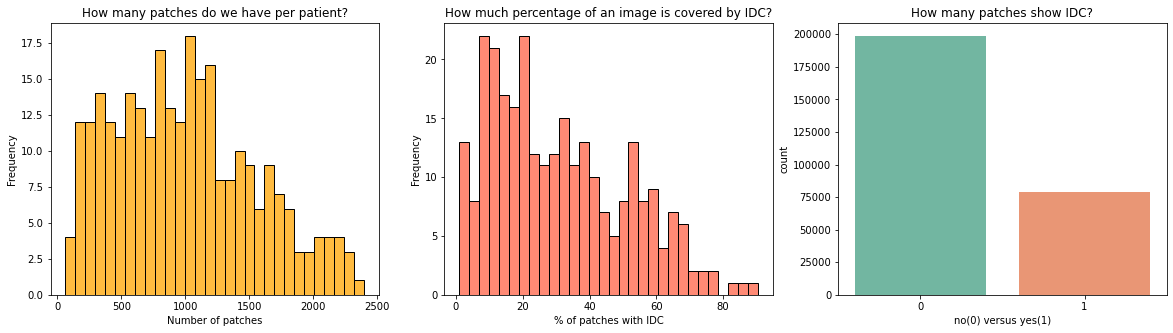

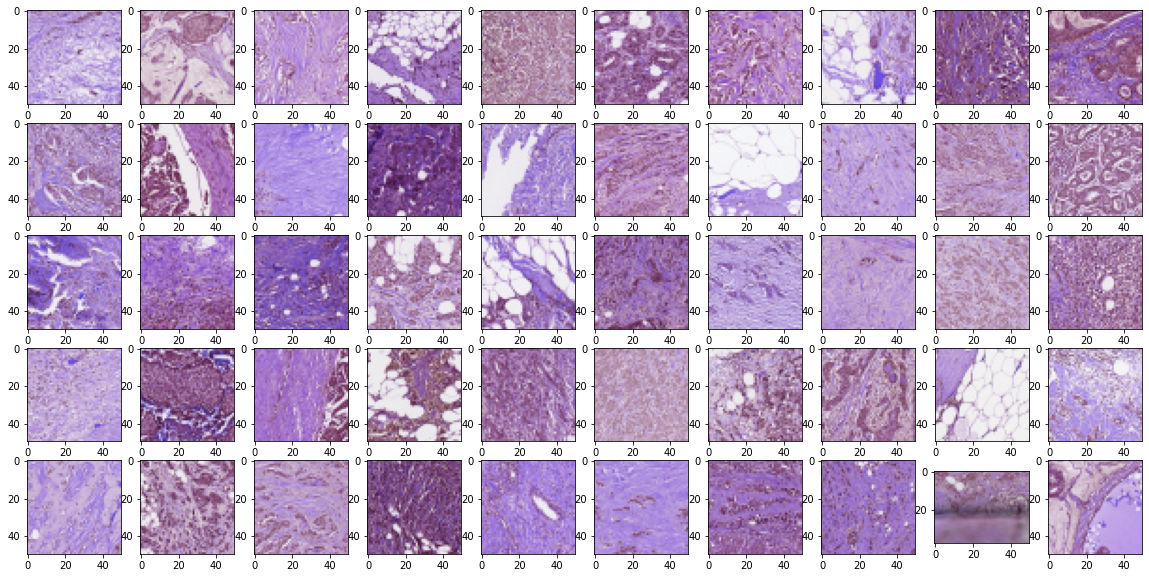

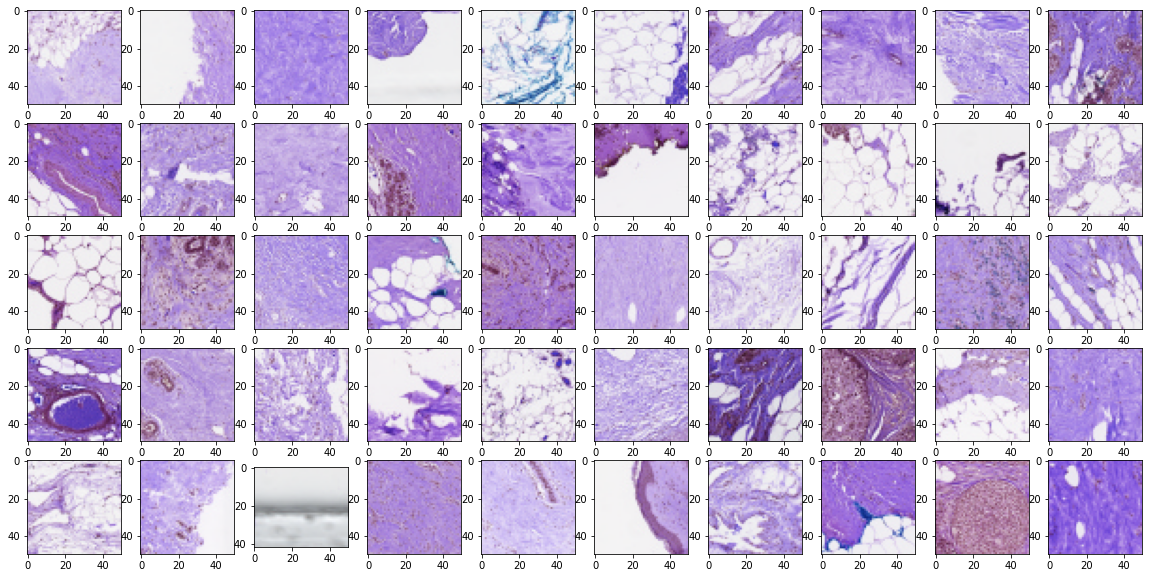

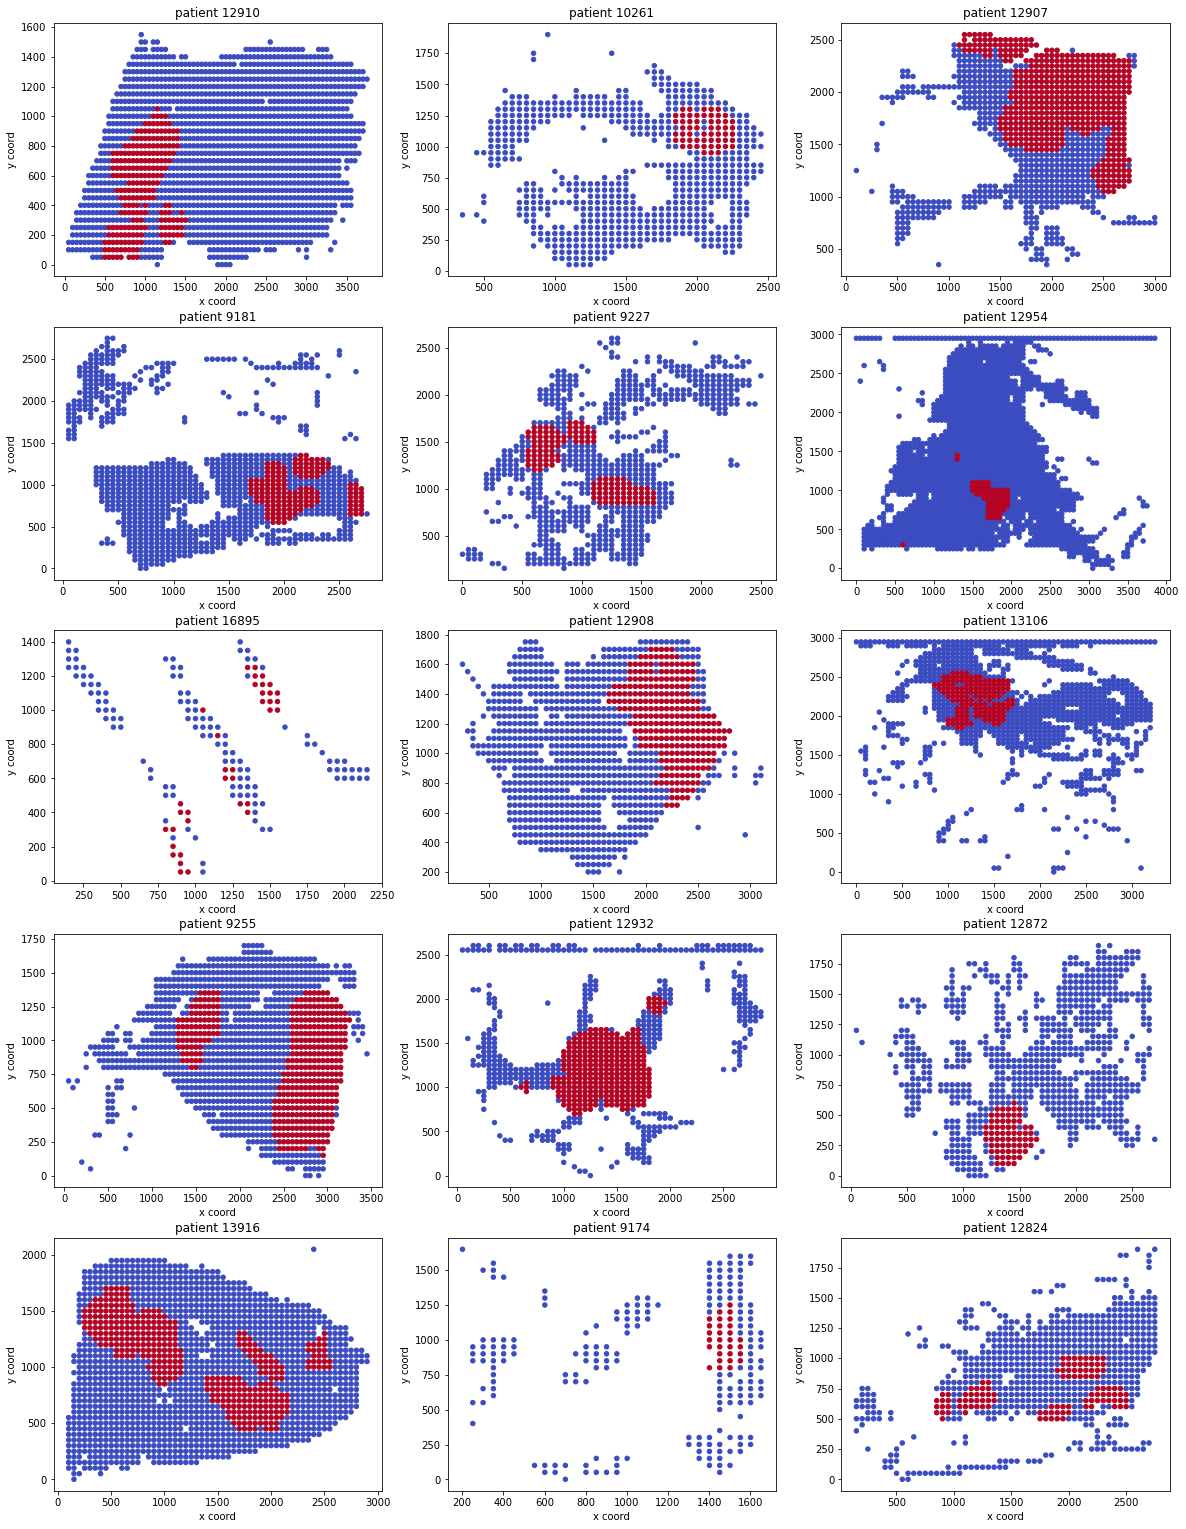

In [ ]:

z=[]
x=[]
X=[]
y=[]
Y=[]
ID=[]
cl=[]
target=[]

Num_Folder=[]
matrix=[] #define empty matrix
i=0
NN='Resnet' ##Choise the Neural Network CNN or Resnet 
# Hyper parameters
num_epochs = 1
num_classes = 2
batch_size = 128
learning_rate = 0.002

for img in imagePatches:
    
    imagePatches1=imagePatches[i].split("/")
    #print(imagePatches1)
    imagePatches2=imagePatches1[5].split("_")
    #print(imagePatches2)
    x=imagePatches2[2].split("x")
    x=x[1]
    #print(x)
    y=imagePatches2[3].split("y")
    y=y[1]
    #print(y)
    target=imagePatches2[4].split(".png")
    cl=target[0]
   
    if cl=='class0':
        cl=0
    elif cl=='class1':
         cl=1
        
    ID=imagePatches2[1]
    Num_Folder=imagePatches2[0]
    filename=imagePatches[i]
    if NN=='CNN':
        X=[filename,cl]
        column_names=["filename","target"]
        matrix.append(X)
    elif NN=='Resnet':
        X=[Num_Folder,x,y,filename,cl]
        column_names=["patient_id","x","y","filename","target"]
        matrix.append(X)
    i=i+1
 #add fully defined column into the row
images_df = pd.DataFrame(matrix,columns=column_names)
images_df.head()
train,val=split_train_val(images_df)
loader_train,loader_valid,dataloaders=dataloader(train,val,batch_size)
if NN=='CNN':
    images_df.to_csv(r'dataset_CNN.csv', index = False)
    loss_array,Test_acc=train_model(num_epochs,num_classes,batch_size,learning_rate,loader_train)
    plt.plot(loss_array)               
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.show()      
else:
    run_training = True
    retrain = False
    find_learning_rate = True
    images_df.to_csv(r'dataset_Resnet.csv', index = False)    
    files = os.listdir("../IDC_regular_ps50_idx5/IDC_regular_ps50_idx5/")
    print(len(files))
    base_path="../IDC_regular_ps50_idx5/IDC_regular_ps50_idx5/"
    folder = os.listdir(base_path)
    print(len(folder))
    # read csv file and dataset created
    dataset,patient_id_Col,target_Col,path_Col,cancer_perc = Dataset_new()
    #print("Insights:")
    Exploratory_analysis(dataset)
    #Looking at healthy and cancer patches
    pos_selection,neg_selection=Positive_or_Negative(dataset)
    #print('cancer_patches')
    cancer_patches(pos_selection)
    #print('Healthy_patches')
    Healthy_patches(neg_selection)
    #Example table
    example = get_patient_dataframe(dataset.patient_id.values[0])
    print(example.head())
    #Binary target visualisation per tissue slice
    tissue_slice(dataset)
    #Let's use an example patient with id 13616:
    patient_id = "13616"
    grid, mask, broken_patches, mask_proba = visualise_breast_tissue(patient_id, pred_df=None)
    example_fig(grid,mask,patient_id)
    #Setting up the machine learning workflow
    BATCH_SIZE,NUM_CLASSES,OUTPUT_PATH,MODEL_PATH,LOSSES_PATH,dataset=Settings()
    train_ids,test_ids,sub_test_ids,dev_ids,patients=split_test_id_dev_id(dataset)
    #Let's take a look at the target distribution difference of the datasets:
    train_df,test_df,dev_df=target_distribution_difference(dataset)
    train_dataset,dev_dataset,test_dataset,dataset_sizes=BreastCancer_target_distribution()
    train_dataloader,dev_dataloader,test_dataloader,dataloaders,device=BreastCancer_dataloaders(train_dataset,dev_dataset,test_dataset)
    model=Model_resnet50()
    start_lr = 1e-6
    end_lr = 0.1
    class_weights=weights(device,train_df)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.Adamax(model.fc.parameters(), end_lr)#torch.optim.SGD(model.fc.parameters(), start_lr)
    lr_find_epochs=1   
    train_loop_resnet50(model,criterion,dataset_sizes, optimizer,lr_find=False,scheduler=None,num_epochs=1,lam=0.0)
    Train_resnet50(start_lr,end_lr,criterion,find_learning_rate)
    start_lr = 1e-6
    end_lr = 0.001
    optimizer = torch.optim.Adamax(model.fc.parameters(), end_lr)#torch.optim.SGD(model.fc.parameters(), start_lr)
    Second_Train_resnet50(model,optimizer,run_training,NUM_EPOCHS,start_lr,end_lr)
    dev_predictions,test_predictions,dev_predictions=Prediction(run_training,dataset_sizes)
    